# ResNet & Lifting Example

In [1]:
%matplotlib inline

import os

# Packages for loading images
from PIL import Image
import requests
from io import BytesIO
import pandas as pd

try:
    import plotters
except:
    !pip install --upgrade git+https://github.com/fbcotter/plotters.git@0.0.4#egg=plotters
    import plotters
    
# Numerical packages
import tensorflow as tf
import numpy as np
import math

# Plotting packages
import matplotlib.pyplot as plt

Import some helpful functions for plotting and convolution - these are nothing special, even if they are lots of lines of code

# Get a test image

In [2]:
# Can use any image url, or a local image if you prefer
example_img = 'http://i.imgur.com/drZUCM5.jpg'
response = requests.get(example_img)
img_pil = Image.open(BytesIO(response.content))
img = np.array(img_pil).astype(np.float32)

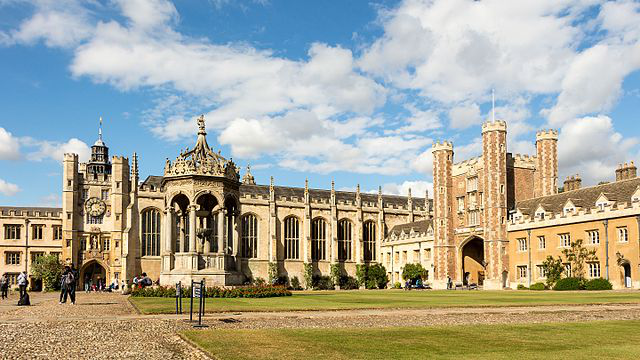

In [3]:
img_pil

# Define Neural Nets

## First, we look at a 'plain' network - i.e. no feedforward summing

In [4]:
def residual_core(x, out_dim, stride):
    """Define the core mapping of a res layer, i.e. F(x)
    """
    strides=(stride, stride)
    
    x = tf.nn.relu(x)
    x = tf.layers.conv2d(x, out_dim, kernel_size=3, strides=strides, 
                         padding='same', use_bias=False, name='sub1')
    x = tf.nn.relu(x)
    x = tf.layers.conv2d(x, out_dim, kernel_size=3, strides=(1,1), 
                         padding='same', use_bias=False, name='sub2')
    
    return x

How can we invert this? The best we can hope for is 'deconvolution' with Zeiler and Fergus' DeconvNets.

In [5]:
def get_static_shape_dyn_batch(x):
    batch = tf.shape(x)[0]
    static = x.get_shape()
    return tf.concat([[batch], static[1:]], axis=0)

def residual_core_inv(x, out_dim, stride):
    """Define the 'inverse' core mapping of a res layer, i.e. F^t(x)
    """
    strides = (stride, stride)
    
    x = tf.layers.conv2d_transpose(
        x, out_dim, kernel_size=3, use_bias=False, strides=strides, name='sub2')
    x = tf.nn.relu(x)
    x = tf.layers.conv2d_transpose(
        x, out_dim, kernel_size=3, use_bias=False, strides=strides, name='sub1')
    x = tf.nn.relu(x)
    return x


In [6]:
tf.reset_default_graph()
x_in = tf.placeholder(tf.float32, [None, *img.shape])

# Forward pass
with tf.variable_scope('layer1'):
    l1 = residual_core(x_in, 3, 1)

with tf.variable_scope('layer2'):
    l2 = residual_core(l1, 3, 1)

with tf.variable_scope('layer3'):
    l3 = residual_core(l2, 3, 1)
    
# Backward pass
with tf.variable_scope('layer3') as scope:
    scope.reuse_variables()
    l2_hat = residual_core_inv(l3, 3, 1)

with tf.variable_scope('layer2') as scope:
    scope.reuse_variables()
    l1_hat = residual_core_inv(l2_hat, 3, 1)

with tf.variable_scope('layer1') as scope:
    scope.reuse_variables()
    img_hat = residual_core_inv(l1_hat, 3, 1)

In [7]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
l1_n, l2_n, l3_n = sess.run([l1, l2, l3], {x_in : [img]})

Now plot the activations from the first 3 layers

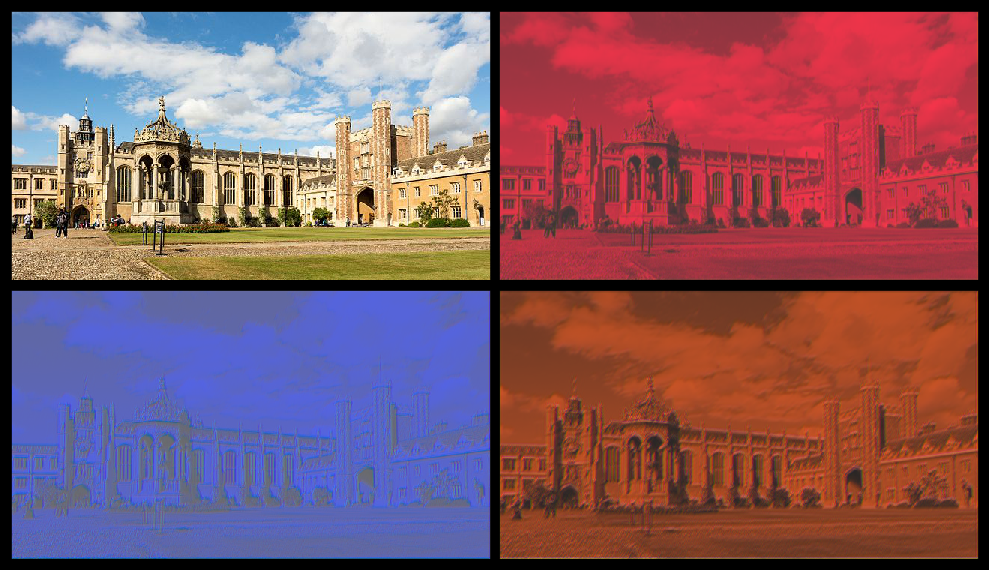

In [8]:
fig, ax = plotters.plot_axgrid(2, 2, figsize=(14,8))
ax[0,0].imshow(plotters.normalize(img))
ax[0,1].imshow(plotters.normalize(l1_n[0]))
ax[1,0].imshow(plotters.normalize(l2_n[0]))
ax[1,1].imshow(plotters.normalize(l3_n[0]))

Now try to reconstruct from the final output

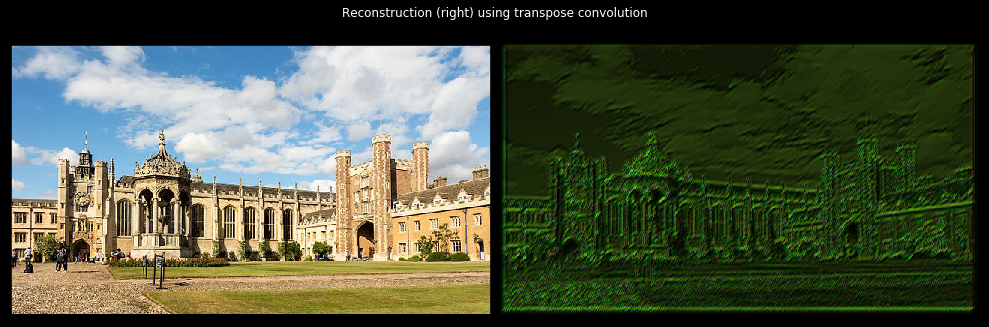

In [9]:
img_hat_n = sess.run(img_hat, {x_in: [img]})
fig, ax = plotters.plot_axgrid(1, 2, figsize=(14,5))
fig.suptitle('Reconstruction (right) using transpose convolution', color='w')
ax[0].imshow(plotters.normalize(img))
ax[1].imshow(plotters.normalize(img_hat_n[0]))

## Residual Nets

In [10]:
def residual(x, out_dim, stride):
    """Define the full residual layer, i.e. x + F(x)
    """
    orig_x = x
    x = residual_core(x, out_dim, stride)
    x += orig_x
    return x

In [11]:
tf.reset_default_graph()
x_in = tf.placeholder(tf.float32, [None, *img.shape])
# Forward pass
with tf.variable_scope('layer1'):
    l1 = residual(x_in, 3, 1)

with tf.variable_scope('layer2'):
    l2 = residual(l1, 3, 1)

with tf.variable_scope('layer3'):
    l3 = residual(l2, 3, 1)
    

In [12]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
l1_n, l2_n, l3_n = sess.run([l1, l2, l3], {x_in : [img]})

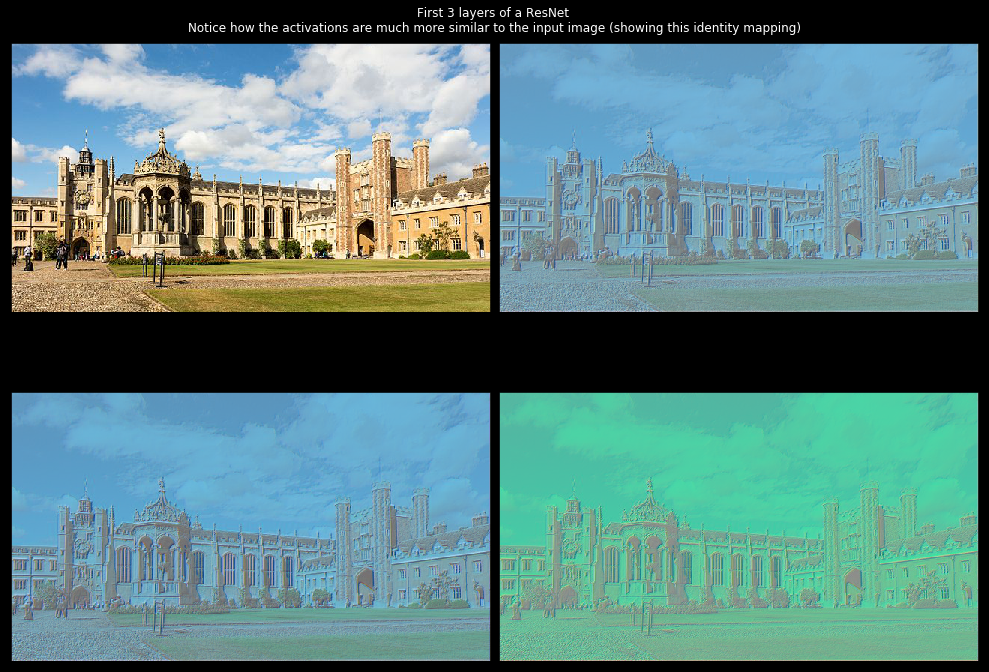

In [13]:
fig, ax = plotters.plot_axgrid(2, 2, figsize=(14,10))
fig.suptitle('''First 3 layers of a ResNet 
Notice how the activations are much more similar to the input image (showing this identity mapping)''', color='w')
ax[0,0].imshow(plotters.normalize(img))
ax[0,1].imshow(plotters.normalize(l1_n[0]))
ax[1,0].imshow(plotters.normalize(l2_n[0]))
ax[1,1].imshow(plotters.normalize(l3_n[0]))

## Lifting Network with ResNet Core
Work on Second Generation wavelets in 1996 generated the lifting framework. This was a way to factorize wavelets into simpler 'lifting' steps. It turns out that it can be used even with non-linear functions, and is an efficient framework to do any invertible transform. Given that resnets fall in the domain of pixel to pixel operations, they could be perfectly invertible. Such a property would be greatly beneficial when it came to interpreting deep networks.

https://link.springer.com/article/10.1007/BF02476026

<img src="https://i.imgur.com/nDv4dvT.png">

The basic procedure is to split the input (in 1D this is by taking every other sample, in 2D this is by using a quincunx sampling pattern. Then using one half of the signal, we could 'predict' the other half, then use the other half to 'update' our predictions. These are the P and U steps in the picture above. 

\begin{eqnarray}
difference &=& d =  x_e - Px_o \\
scale &=& s= x_o + Ud
\end{eqnarray}

Inverting this is then simple, even if P and O are non-linear transformations, as in ResNets. The only requirement is that they must not change the pixel volume.

\begin{eqnarray}
x_o &=& s - Ud \\
x_e &=& d + Px_o
\end{eqnarray}

This gives us an idea - how easy would it be to implement a lift-residual block? Note that we don't have to implement the splitting either - this certainly makes it more efficient, but we could easily copy the input to both rungs of the lattice.

In [14]:
def lift_residual(x_even, x_odd, out_dim, stride):
    """Define a Lifting Layer
    
    The P and the U blocks for this lifting layer are non-linear functions. 
    These are the same form as the F(x) in a residual layer (i.e. two
    convolutions)
    """
    with tf.variable_scope('P'):
        # Calculate d = x_e - Px_o
        d = x_even - residual_core(x_odd, out_dim, stride)
    
    with tf.variable_scope('U'):
        # Calculate s = x_o + Ud
        s = x_odd + residual_core(d, out_dim, stride)
    
    return d, s

In [15]:
def lift_residual_inv(d, s, out_dim, stride):
    """Define the inverse of a lifting layer
    
    Share the variables with the forward lifting.
    """
    with tf.variable_scope('U') as scope:
        # Calculate x_o = s - Ud
        scope.reuse_variables()        
        x_o = s - residual_core(d, out_dim, stride)
    
    with tf.variable_scope('P') as scope:
        # Calculate x_e = d + Px_o
        scope.reuse_variables() 
        x_e = d + residual_core(x_o, out_dim, stride)
        
    return x_e, x_o    

In [16]:
tf.reset_default_graph()
x_even = tf.placeholder(tf.float32, [None, *img.shape])
x_odd = tf.placeholder(tf.float32, [None, *img.shape])

# Forward pass
with tf.variable_scope('layer1'):
    d1, s1 = lift_residual(x_even, x_odd, 3, 1)

with tf.variable_scope('layer2'):
    d2, s2 = lift_residual(d1, s1, 3, 1)

with tf.variable_scope('layer3'):
    d3, s3 = lift_residual(d2, s2, 3, 1)
    d2_hat, s2_hat = lift_residual_inv(d3, s3, 3, 1)

with tf.variable_scope('layer2'):
    d1_hat, s1_hat = lift_residual_inv(d2_hat, s2_hat, 3, 1)
    
with tf.variable_scope('layer1'):
    x_even_hat, x_odd_hat = lift_residual_inv(d1_hat, s1_hat, 3, 1)

In [17]:
# Note that we feed in x to both the 'even' and 'odd' inputs, rather than splitting 
sess = tf.Session()
sess.run(tf.global_variables_initializer())
d1_n, s1_n, d2_n, s2_n, d3_n, s3_n, x_even_hat_n, x_odd_hat_n = sess.run(
    [d1, s1, d2, s3, d3, s3, x_even_hat, x_odd_hat], 
    {x_even: [img], x_odd:[img]})

Plot the 's' and 'd' images at each layer of the lattice

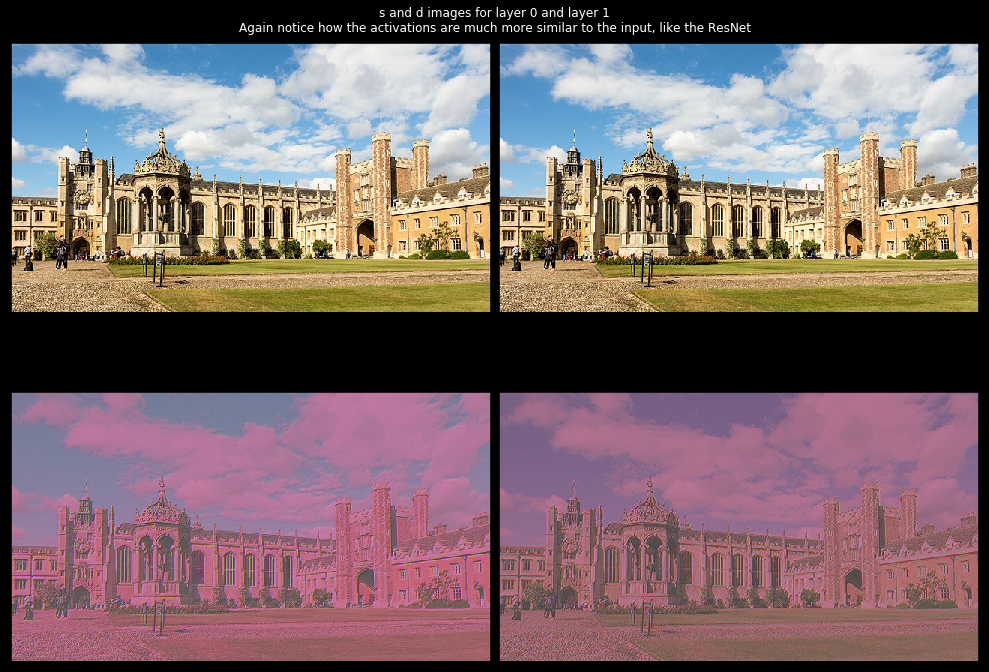

In [18]:
fig, ax = plotters.plot_axgrid(2, 2, figsize=(14,10))
fig.suptitle('''s and d images for layer 0 and layer 1
Again notice how the activations are much more similar to the input, like the ResNet''', color='w')
ax[0,0].imshow(plotters.normalize(img))
ax[0,1].imshow(plotters.normalize(img))
ax[1,0].imshow(plotters.normalize(d1_n[0]))
ax[1,1].imshow(plotters.normalize(s1_n[0]))

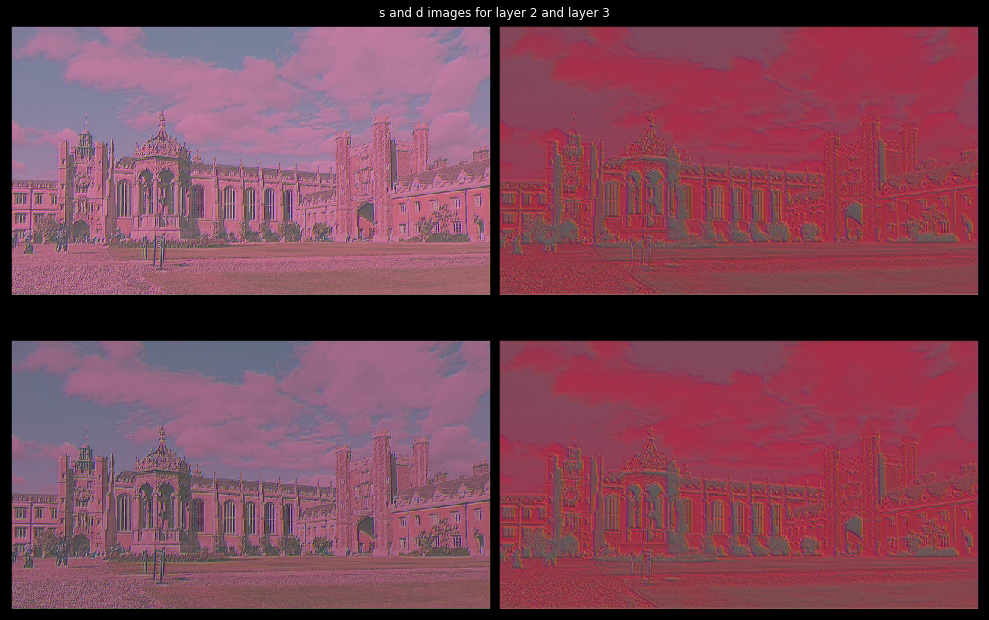

In [19]:
fig, ax = plotters.plot_axgrid(2, 2, figsize=(14,9))
fig.suptitle('s and d images for layer 2 and layer 3', color='w')
ax[0,0].imshow(plotters.normalize(d2_n[0]))
ax[0,1].imshow(plotters.normalize(s2_n[0]))
ax[1,0].imshow(plotters.normalize(d3_n[0]))
ax[1,1].imshow(plotters.normalize(s3_n[0]))

In comparison to above - reconstruction is a breeze!

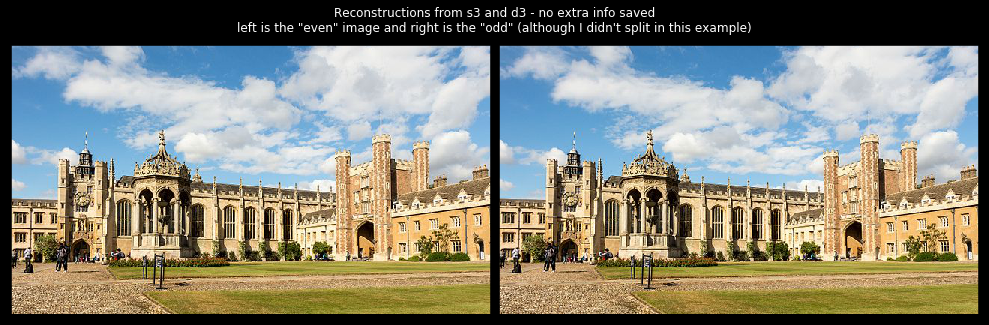

In [20]:
fig, ax = plotters.plot_axgrid(1, 2, figsize=(14,5))
fig.suptitle('''Reconstructions from s3 and d3 - no extra info saved
left is the "even" image and right is the "odd" (although I didn't split in this example)''', color='w')
ax[0].imshow(plotters.normalize(x_even_hat_n[0]))
ax[1].imshow(plotters.normalize(x_odd_hat_n[0]))